# Setup

Import libraries

In [6]:
import pandas as pd

from scipy.stats import norm
import numpy as np
import pymc as pm
import arviz as az
import xarray as xr 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams.update({"font.family":"Arial", 
                     "font.size": 8 ,
                     "axes.labelweight": "bold",
                     "axes.titleweight": "bold",
                     "legend.frameon": False,
                     "text.latex.preamble": r'\boldmath'})

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 


Load data

In [59]:
data = pd.read_csv("./data/Howell1.csv",delimiter=';')
adults = data[data.age >= 18]
adults.head()


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


# Section 4.3 -  Gaussian model of height

## Data visualization

From book:
> Our goal is to model these values using a Gaussian distribution. First, go ahead and plot the distribution of heights...

Let's fit a Gaussian and then plot the histogram and the Gaussian fit together.

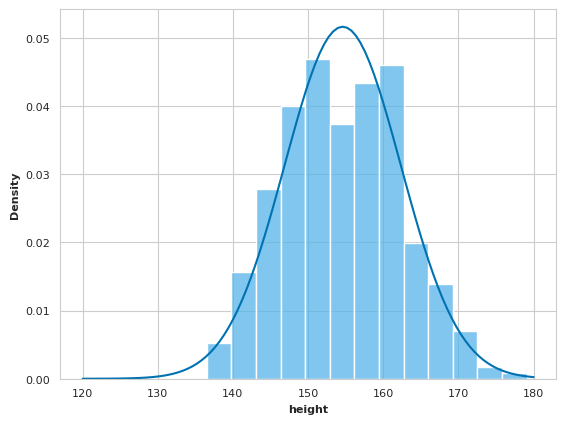

In [8]:
mean, std = norm.fit(adults.height)
xx = np.linspace(120,180,100)

with sns.axes_style("whitegrid"):
    sns.histplot(data=adults, x="height",color=skyblue,stat="density")
    plt.plot(xx, norm.pdf(xx,mean,std),color=blue_cb)

## Height only model

Now let's fit a `pymc` model and see what our parameter estimates look like. We will formulate the model and priors exactly as in the book. 

$$
\begin{align*}
h_i \sim \text{Normal}(\mu, \sigma)\\
\mu \sim \text{Normal}(178, 20)\\
\sigma \sim \text{Normal}(0, 50)\\
\end{align*}
$$

This is a little overkill here but its a nice warm-up for later models. 


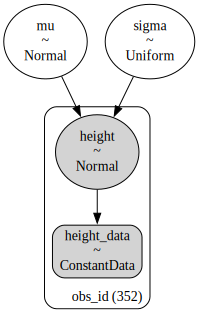

In [9]:
with pm.Model() as height_model: 
    
    # Data
    height_data = pm.ConstantData("height_data",adults.height,dims="obs_id")

    # Priors
    mu    = pm.Normal('mu',178, 20)
    sigma = pm.Uniform('sigma',0,50)

    # Likelihood
    height = pm.Normal("height",mu=mu, sigma=sigma,observed=height_data,dims="obs_id")

pm.model_to_graphviz(height_model)


In [10]:
with height_model:
    height_model_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


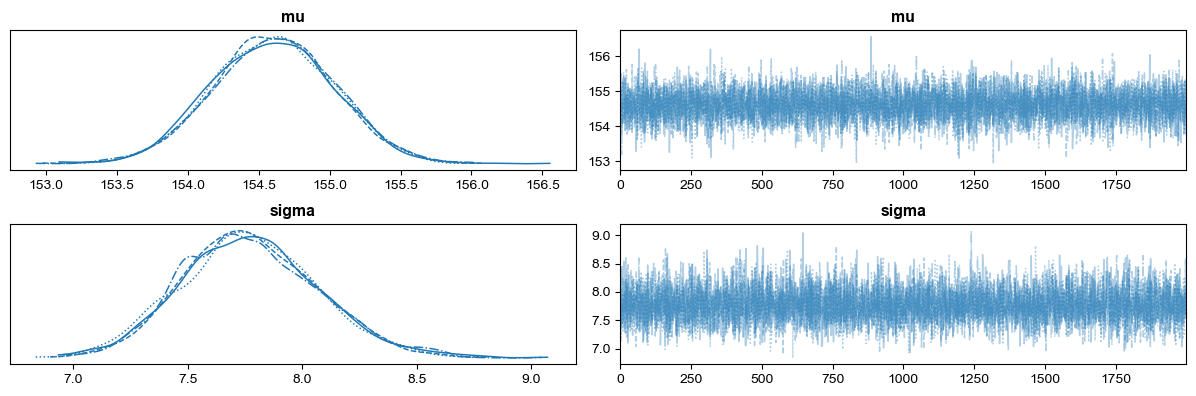

In [16]:
az.plot_trace(height_model_trace)
plt.tight_layout()

Let's check the parameters.

In [17]:
az.summary(height_model_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.60,0.43,153.79,155.38,0.0,0.0,8109.26,6386.19,1.0
sigma,7.77,0.30,7.23,8.34,0.0,0.0,8291.36,5233.82,1.0


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

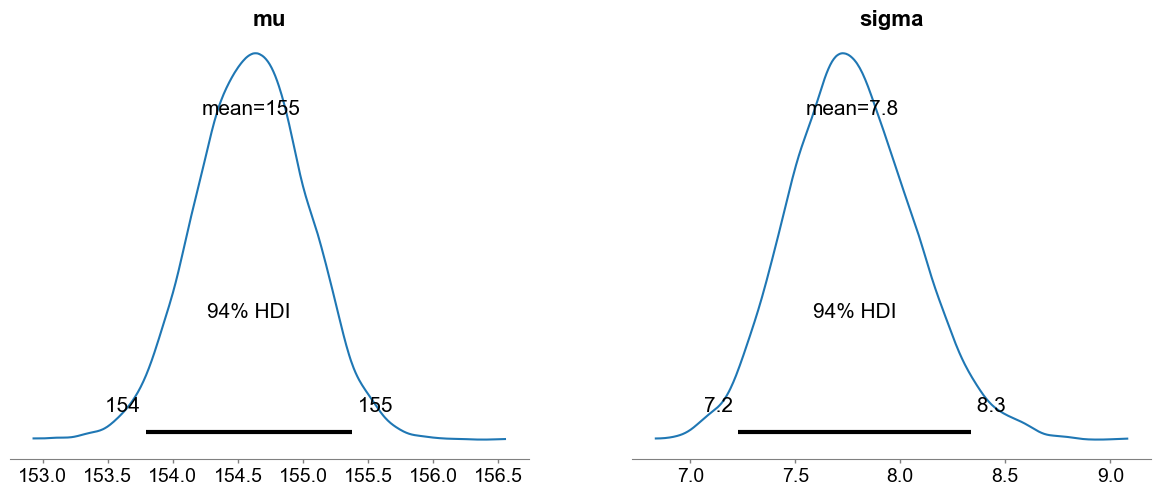

In [18]:
az.plot_posterior(height_model_trace)

Sample the posterior predictive

<Axes: xlabel='height / height'>

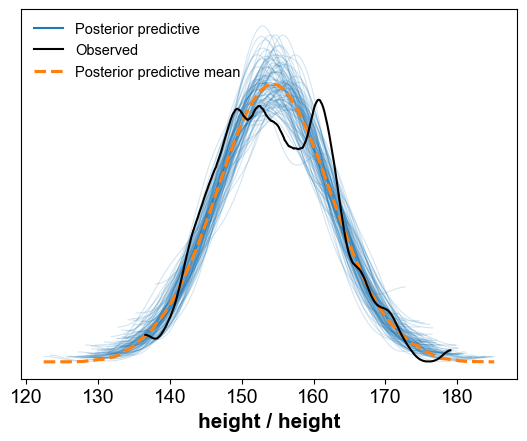

In [19]:
with height_model:
    pm.sample_posterior_predictive(height_model_trace,extend_inferencedata = True)

az.plot_ppc(height_model_trace, num_pp_samples=100,observed=True)

# Section 4.4 - Linear prediction

Now let's define a linear model that explains the relationship between height and weight. 


$$
\begin{align*}
h_i & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = \alpha + \beta(x_i - \bar{x})\\
\alpha & \sim \text{Normal}(178, 20)\\
\beta & \sim \text{Normal}(0,10)\\
\sigma & \sim \text{Uniform}(0, 50)\\
\end{align*}
$$

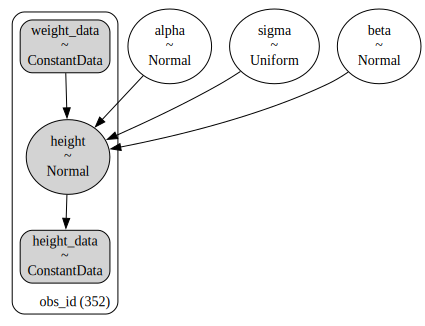

In [169]:
with pm.Model() as linear_model:

    # Data
    height_data = pm.ConstantData("height_data",adults.height,dims="obs_id")
    weight_data = pm.ConstantData("weight_data",adults.weight,dims="obs_id")

    # Priors
    alpha    = pm.Normal('alpha',178, 20)
    beta     = pm.Normal('beta' , 0, 10)
    sigma    = pm.Uniform('sigma',0,50)

    # Linear model
    mu = alpha + beta*weight_data
    
    # Likelihood
    height = pm.Normal("height",mu=mu, sigma=sigma,observed=height_data,dims="obs_id")
    
# Check the graph
pm.model_to_graphviz(linear_model)



Let's run some prior predictive checks

Sampling: [alpha, beta, height, sigma]


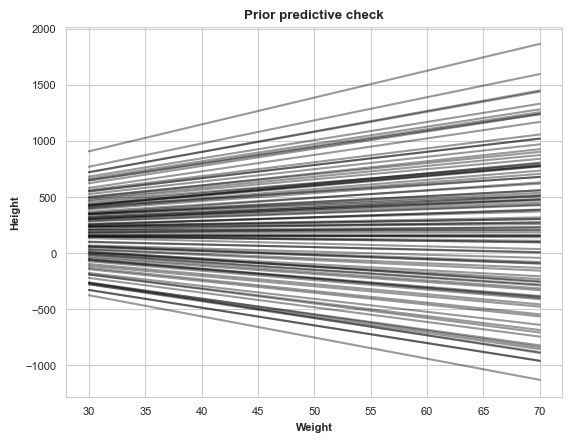

In [44]:
with linear_model:
    prior_check_linear_model = pm.sample_prior_predictive(samples=100,return_inferencedata=True)

x = xr.DataArray(np.linspace(30,70,100), dims=["plot_dim"])
y = prior_check_linear_model.prior["alpha"] +  prior_check_linear_model.prior["beta"] * x

with sns.axes_style("whitegrid"):
    # Plot prior predictive
    _, ax = plt.subplots()
    ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Height")
    ax.set_title("Prior predictive check")


Well, this obviously looks terrible. The scale is way off and we have positive and negative relationships. The latter is biologically implausible so let's fix our priors a bit. We will also standardize our data. 

In [98]:
# from scipy.stats import zscore

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


adults["height_zscore"] = standardize(adults["height"])
adults["weight_zscore"] = standardize(adults["weight"])

### Centered Linear model

$$
\begin{align*}
h_i & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = \alpha + \beta(x_i - \bar{x})\\
\alpha & \sim \text{Normal}(178, 20)\\
\beta & \sim \text{Uniform}(0,10)\\
\sigma & \sim \text{Uniform}(0, 50)\\
\end{align*}
$$

Alternatively, we can do what is in the book and assign

$$ \beta \sim \text{Log-Normal}(0,1),$$ 

but this does not make a difference for this simple model. Either cases imposes a constraint that the slopes will be positive (although technical the uniform prior allows zero and the log-normal does not...meh).


Sampling: [alpha, beta, height, sigma]


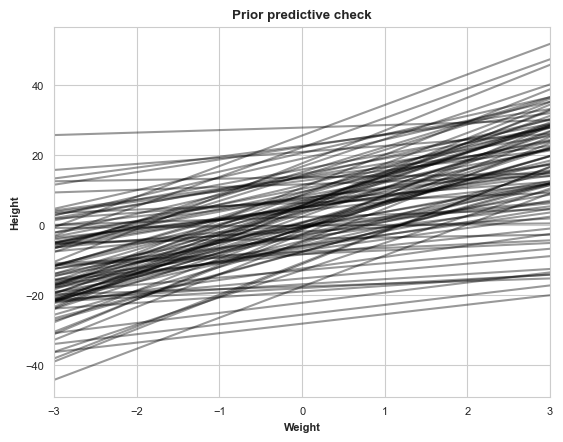

In [149]:
with pm.Model() as centered_linear_model:

    # Data
    height_data = pm.ConstantData("height_data",adults.height_zscore,dims="obs_id")
    weight_data = pm.ConstantData("weight_data",adults.weight_zscore,dims="obs_id")

    # Priors
    alpha    = pm.Normal('alpha',0,10)
    beta     = pm.Uniform('beta' , 0, 10) # pm.LogNormal('beta',0,1) #
    sigma    = pm.Uniform('sigma',0,50)

    # Linear model
    mu = alpha + beta*weight_data
    
    # Likelihood
    height = pm.Normal("height",mu=mu, sigma=sigma,observed=height_data,dims="obs_id")
    
# Check the graph
pm.model_to_graphviz(centered_linear_model)

with centered_linear_model:
    prior_check_centered_linear_model = pm.sample_prior_predictive(samples=100,return_inferencedata=True)

x = xr.DataArray(np.linspace(-3,3,100), dims=["plot_dim"])
y = prior_check_centered_linear_model.prior["alpha"] +  prior_check_centered_linear_model.prior["beta"] * x

with sns.axes_style("whitegrid"):
    # Plot prior predictive
    _, ax = plt.subplots()
    ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Height")
    ax.set_title("Prior predictive check")
    ax.set_xlim(-3,3)
    



Let's sample this and check our posterior.

In [150]:
with centered_linear_model:
    centered_linear_model_trace = pm.sample(1000,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [151]:
az.summary(centered_linear_model_trace, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0000,0.0348,-0.0664,0.0636,0.0005,0.0005,5857.5912,3217.7086,1.0003
beta,0.7548,0.0360,0.6867,0.8219,0.0005,0.0003,6198.9116,2914.9720,1.0011
sigma,0.6595,0.0247,0.6128,0.7048,0.0003,0.0002,6838.4979,2893.2434,1.0007


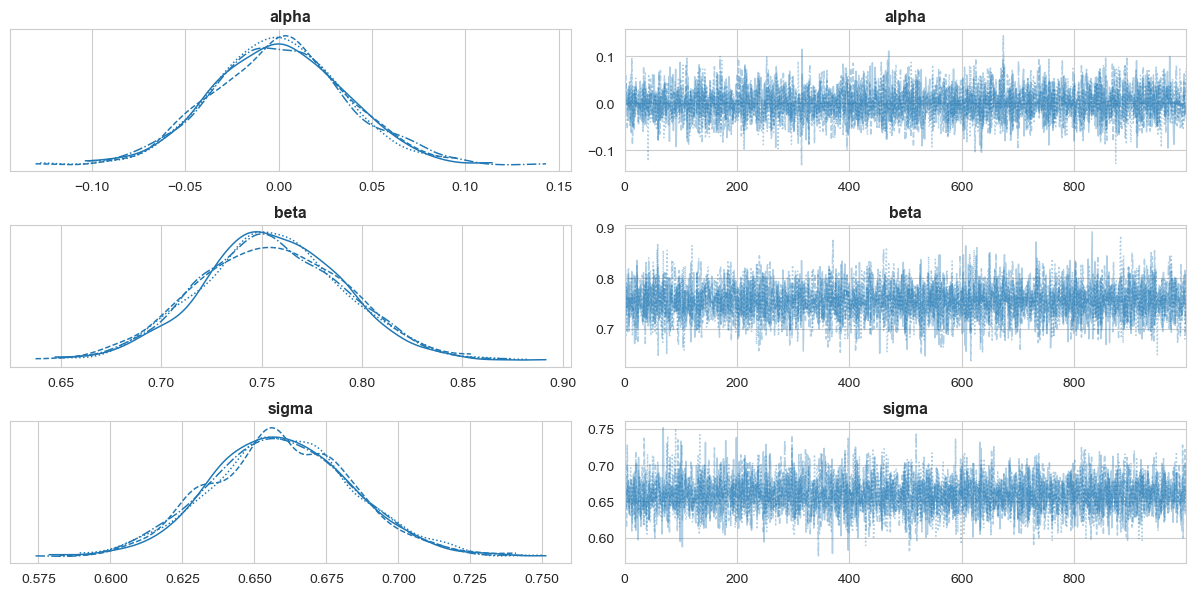

In [152]:
az.plot_trace(centered_linear_model_trace)
plt.tight_layout()


<Axes: xlabel='height / height'>

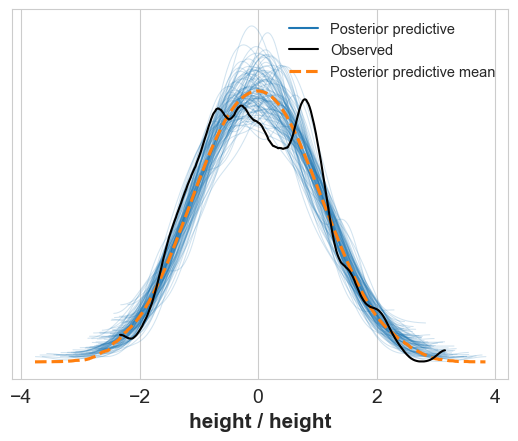

In [153]:
with centered_linear_model:
    pm.sample_posterior_predictive(centered_linear_model_trace,extend_inferencedata = True)

az.plot_ppc(centered_linear_model_trace, num_pp_samples=100,observed=True)

Let's look at our model fit on the data.

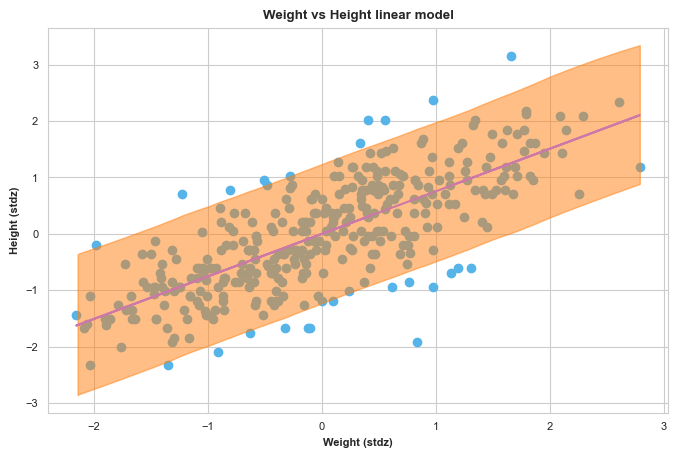

In [168]:
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()

    # Plot observed data
    ax.scatter(data=adults,x="weight_zscore",y="height_zscore",color=skyblue)

    # Plot mean fit
    _likelihood = centered_linear_model_trace["posterior"]["alpha"] + centered_linear_model_trace["posterior"]["beta"]*xr.DataArray(adults["weight_zscore"],dims=['obs_id'])
    ax.plot(
            adults["weight_zscore"],
            _likelihood.mean(("chain","draw")),
            color=pink
            )
    
    # Plot HDI
    az.plot_hdi(
                adults["weight_zscore"],
                centered_linear_model_trace["posterior_predictive"]["height"]
                )

    # Clean up
    ax.set(xlabel = "Weight (stdz)",
           ylabel = "Height (stdz)",
           title  = "Weight vs Height linear model")

# 4.5 Curves from lines 

Now we will look at the full dataset and not just the adults.
## Polynomial models

Let's add a polynomial term. We will show the generative models for the second order and third order models. 

$$
\begin{align*}
h_i & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = \alpha + \beta _1 x_i + \beta _2 x_i^2\\
\alpha & \sim \text{Normal}(178, 20)\\
\beta _1 & \sim \text{Log-Normal}(0,1)\\
\beta _2 & \sim \text{Normal}(0,1)\\
\sigma & \sim \text{Uniform}(0, 50)\\
\end{align*}
$$

Let's add a polynomial term. We will show the generative models for the second order, but the third order will be essentiall the same with the added cubic term.

$$
\begin{align*}
h_i & \sim \text{Normal}(\mu_i, \sigma)\\
\mu_i & = \alpha + \beta _1 x_i + \beta _2 x_i^2 + \beta _3 x_i^3\\
\alpha & \sim \text{Normal}(178, 20)\\
\beta _1 & \sim \text{Log-Normal}(0,1)\\
\beta _2 & \sim \text{Normal}(0,1)\\
\beta _3 & \sim \text{Normal}(0,1)\\
\sigma & \sim \text{Uniform}(0, 50)\\
\end{align*}
$$

Let's check out the data and see why the polynomial model might be useful. 

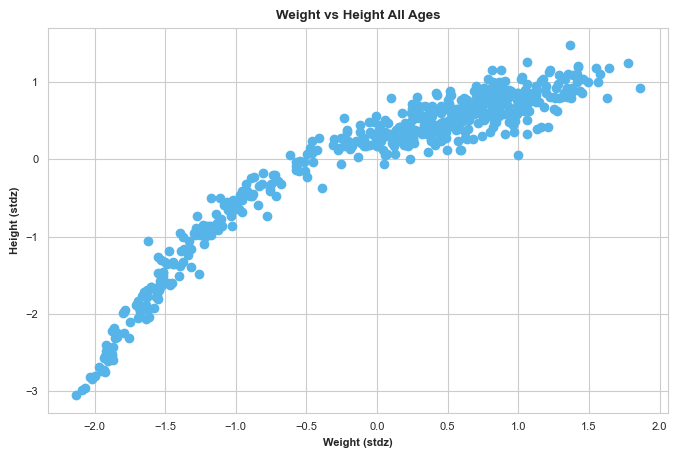

In [178]:
data["height_zscore"] = standardize(data["height"])
data["weight_zscore"] = standardize(data["weight"])

with sns.axes_style("whitegrid"):
    
    # Make figure
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()

    # Plot observed data
    ax.scatter(data=data,x="weight_zscore",y="height_zscore",color=skyblue)


    # Clean up
    ax.set(xlabel = "Weight (stdz)",
           ylabel = "Height (stdz)",
           title  = "Weight vs Height All Ages")


### Second order model

Sampling: [alpha, beta_1, beta_2, height, sigma]


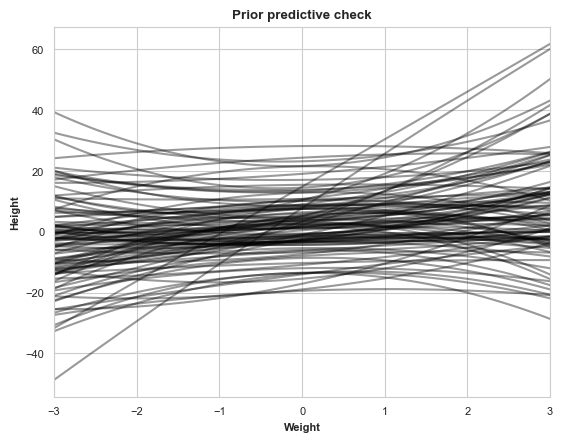

In [175]:
with pm.Model() as second_order_model:

    # Data
    height_data = pm.ConstantData("height_data",data.height_zscore,dims="obs_id")
    weight_data = pm.ConstantData("weight_data",data.weight_zscore,dims="obs_id")

    # Priors
    alpha    = pm.Normal('alpha',0,10)
    beta_1     = pm.LogNormal('beta_1' , 0, 1)
    beta_2     = pm.Normal('beta_2' , 0, 1) 
    sigma    = pm.Uniform('sigma',0,50)

    # Linear model
    mu = alpha + beta_1*weight_data + beta_2*weight_data**2
    
    # Likelihood
    height = pm.Normal("height",mu=mu, sigma=sigma,observed=height_data,dims="obs_id")
    
# Check the graph
pm.model_to_graphviz(second_order_model)

with second_order_model:
    prior_check_centered_linear_model = pm.sample_prior_predictive(samples=100,return_inferencedata=True)

x = xr.DataArray(np.linspace(-3,3,100), dims=["plot_dim"])
y = prior_check_centered_linear_model.prior["alpha"] +  prior_check_centered_linear_model.prior["beta_1"] * x + prior_check_centered_linear_model.prior["beta_2"] * x**2

with sns.axes_style("whitegrid"):
    # Plot prior predictive
    _, ax = plt.subplots()
    ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Height")
    ax.set_title("Prior predictive check")
    ax.set_xlim(-3,3)
    



In [179]:
with second_order_model:
    second_order_model_trace = pm.sample(1000,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_1, beta_2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [180]:
az.summary(second_order_model_trace, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.3044,0.0135,0.2784,0.3294,0.0003,0.0002,2588.0034,2737.1348,1.0003
beta_2,-0.3048,0.0100,-0.3236,-0.2864,0.0002,0.0001,2479.3112,2509.5875,0.9998
beta_1,0.7757,0.0104,0.7559,0.7944,0.0002,0.0001,2792.6722,2921.1834,1.0004
sigma,0.2092,0.0062,0.1983,0.2216,0.0001,0.0001,3407.0058,3082.3289,1.0011


Sampling: [height]


<Axes: xlabel='height / height'>

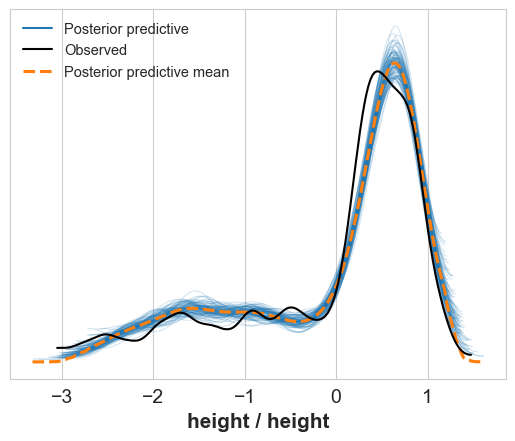

In [182]:
with second_order_model:
    pm.sample_posterior_predictive(second_order_model_trace,extend_inferencedata = True)

az.plot_ppc(second_order_model_trace, num_pp_samples=100,observed=True)

### Third order model

Sampling: [alpha, beta_1, beta_2, beta_3, height, sigma]


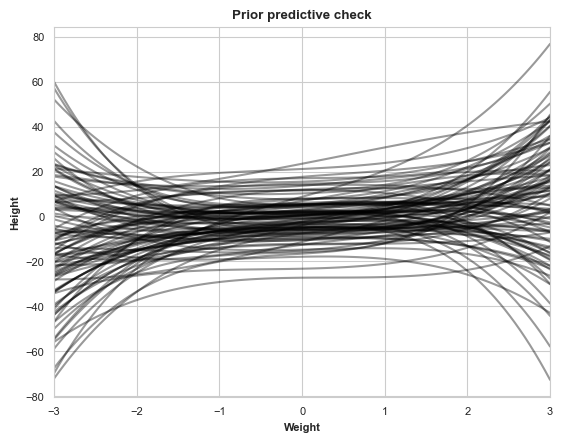

In [190]:
with pm.Model() as third_order_model:

    # Data
    height_data = pm.ConstantData("height_data",data.height_zscore,dims="obs_id")
    weight_data = pm.ConstantData("weight_data",data.weight_zscore,dims="obs_id")

    # Priors
    alpha    = pm.Normal('alpha',0,10)
    beta_1     = pm.LogNormal('beta_1' , 0, 1)
    beta_2     = pm.Normal('beta_2' , 0, 1) 
    beta_3     = pm.Normal('beta_3' , 0, 1) 
    sigma    = pm.Uniform('sigma',0,50)

    # Linear model
    mu = alpha + beta_1*weight_data + beta_2*weight_data**2 + beta_3*weight_data**3
    
    # Likelihood
    height = pm.Normal("height",mu=mu, sigma=sigma,observed=height_data,dims="obs_id")
    
# Check the graph
pm.model_to_graphviz(second_order_model)

with third_order_model:
    prior_check_centered_linear_model = pm.sample_prior_predictive(samples=100,return_inferencedata=True)

x = xr.DataArray(np.linspace(-3,3,100), dims=["plot_dim"])
y = prior_check_centered_linear_model.prior["alpha"] +  \
    prior_check_centered_linear_model.prior["beta_1"] * x + \
    prior_check_centered_linear_model.prior["beta_2"] * x**2 + \
    prior_check_centered_linear_model.prior["beta_3"] * x**3 

with sns.axes_style("whitegrid"):
    # Plot prior predictive
    _, ax = plt.subplots()
    ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Height")
    ax.set_title("Prior predictive check")
    ax.set_xlim(-3,3)
    



In [191]:
with third_order_model:
    third_order_model_trace = pm.sample(1000,)

az.summary(third_order_model_trace, round_to=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_1, beta_2, beta_3, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.3068,0.0115,0.2843,0.3274,0.0002,0.0002,2822.7053,2498.9865,1.0006
beta_2,-0.2371,0.0097,-0.2552,-0.2188,0.0002,0.0001,2385.4520,2190.3239,1.0003
beta_3,0.1296,0.0086,0.1137,0.1459,0.0002,0.0001,2175.4475,2049.1153,1.0019
beta_1,0.5455,0.0178,0.5122,0.5792,0.0004,0.0003,2279.5843,2331.8824,1.0020
sigma,0.1756,0.0054,0.1657,0.1862,0.0001,0.0001,3320.0365,2493.9177,1.0007


<Axes: xlabel='height / height'>

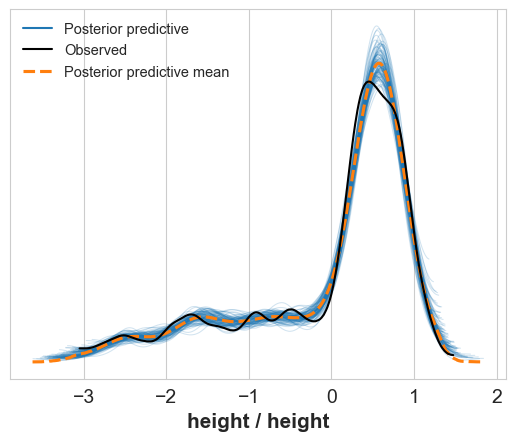

In [193]:
with third_order_model:
    pm.sample_posterior_predictive(third_order_model_trace,extend_inferencedata = True)

az.plot_ppc(third_order_model_trace, num_pp_samples=100,observed=True)

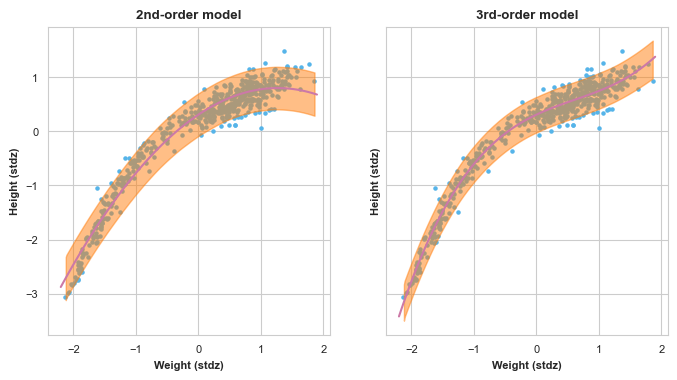

In [229]:
with sns.axes_style("whitegrid"):
    
    # Make figure
    fig, ax = plt.subplots(1,2,sharey=True, sharex=True)
    fig.set_size_inches(8,4)

    # Plot observed data
    ax[0].scatter(data=data,x="weight_zscore",y="height_zscore",color=skyblue,s=5)
 
    
    # Plot mean fit
    xx = xr.DataArray(np.linspace(-2.2,1.9,100),dims=['obs_id'])
    _likelihood_2nd = second_order_model_trace["posterior"]["alpha"] + second_order_model_trace["posterior"]["beta_1"]*xx + \
                      second_order_model_trace["posterior"]["beta_2"]*xx**2 


    ax[0].plot(
            xx,
            _likelihood_2nd.mean(("chain","draw")),
            color=pink
            )
    
    # Plot HDI
    az.plot_hdi(
                data["weight_zscore"],
                second_order_model_trace["posterior_predictive"]["height"],
                ax=ax[0]
                )

    # Clean up
    ax[0].set(xlabel = "Weight (stdz)",
           ylabel = "Height (stdz)",
           title  = "2nd-order model")
    


    # Plot observed data
    ax[1].scatter(data=data,x="weight_zscore",y="height_zscore",color=skyblue,s=5)
 
    
    # Plot mean fit
    xx = xr.DataArray(np.linspace(-2.2,1.9,100),dims=['obs_id'])
    _likelihood_3rd = third_order_model_trace["posterior"]["alpha"] + third_order_model_trace["posterior"]["beta_1"]*xx + \
                      third_order_model_trace["posterior"]["beta_2"]*xx**2 + \
                      third_order_model_trace["posterior"]["beta_3"]*xx**3
                      


    ax[1].plot(
            xx,
            _likelihood_3rd.mean(("chain","draw")),
            color=pink
            )
    
    # Plot HDI
    az.plot_hdi(
                data["weight_zscore"],
                third_order_model_trace["posterior_predictive"]["height"],
                ax=ax[1]
                )

    # Clean up
    ax[1].set(xlabel = "Weight (stdz)",
           ylabel = "Height (stdz)",
           title  = "3rd-order model")

## Splines!

NOTE: I found this link after completing this notebook but it is a similar, but very clean, implementation of the spline regression.

https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html

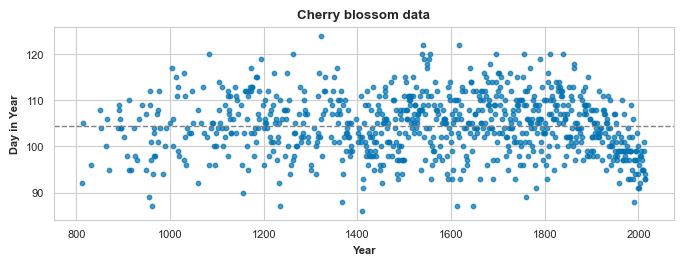

In [254]:
data = pd.read_csv('./data/cherry_blossoms.csv',sep=';')

with sns.axes_style("whitegrid"):
    
    # Make figure
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_subplot()

    # Plot observed data
    ax.scatter(data=data,x="year",y="doy",color=blue_cb,alpha=0.7,s=10)

    # Plot mean
    ax.axhline(y=data.doy.mean(),color=(0.5,0.5,0.5),linestyle='--',lw=1)

    # Clean up
    ax.set(xlabel = "Year",
           ylabel = "Day in Year",
           title  = "Cherry blossom data")

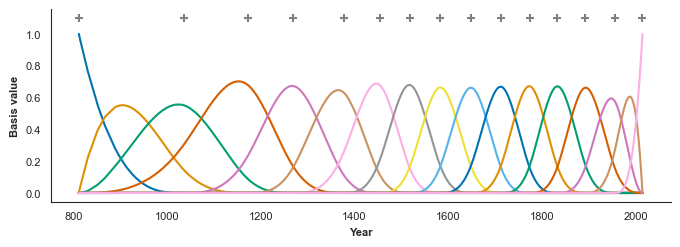

In [427]:
from patsy import dmatrix
num_knots = 15

# This is the key here. Drop the rows where DOY is missing and then compute quantiles on year data
d2 = data.dropna(subset=["doy"]).reset_index(drop=True)
knot_list = np.quantile(d2.year,q=np.linspace(0,1,num_knots))

# Use patsy to compute the basis functions and return dmatrix
basis = dmatrix("bs(x, knots=knots, degree=3,include_intercept=True)-1",
             {"x": d2.year.values, "knots":knot_list[1:-1]})

with sns.axes_style("white"):
    with sns.color_palette("colorblind"):
        # Make figure
        fig = plt.figure(figsize=(8,2.5))
        ax = fig.add_subplot()
        
        # Plot basis functions
        ax.plot(d2.year.values, np.asarray(basis))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        # Add knot markers
        ax.scatter(knot_list,np.ones((1,num_knots))+.1,marker='+',color=grey)
        ax.set(xlabel="Year",
               ylabel="Basis value")

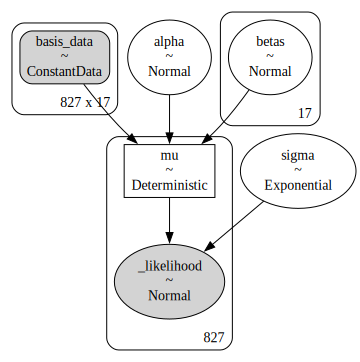

In [503]:
coords = {"weights" : np.arange(basis.shape[1])}


with pm.Model(coords=coords) as spline_model:
    
    # Data
    basis_data = pm.ConstantData("basis_data",np.asarray(basis))

    # Prior on intercept
    alpha = pm.Normal("alpha",100,10) 

    # Prior on weights
    betas = pm.Normal("betas",0,10,shape=basis.shape[1])#dims="weights")
    # betas = pm.Normal("betas",0,10,dims="weights")

    # Noise
    sigma = pm.Exponential('sigma',1)

    # Likelihood mean -> call deterministic so pymc knows to track the value
    mu = pm.Deterministic('mu',alpha + pm.math.dot(basis_data,betas.T))
    
    # mu = alpha + np.asarray(basis)*betas.T

    # Likelihiood
    _likelihood = pm.Normal("_likelihood",mu=mu, sigma=sigma,observed=d2.doy)#,dims="obs_id")
    
# Check the graph
pm.model_to_graphviz(spline_model)

In [504]:
with spline_model:
    spline_model_trace = pm.sample(1000,)

az.summary(spline_model_trace, round_to=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int64 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int64 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int64 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int64 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,103.6680,2.3345,98.8647,107.6578,0.0947,0.0670,609.7368,794.8423,1.0063
betas[0],-3.3328,3.8005,-10.6073,3.9855,0.1038,0.0734,1337.1238,2160.8933,1.0029
betas[1],-1.1600,3.8494,-8.2558,6.1141,0.1077,0.0762,1279.1502,2151.3051,1.0022
betas[2],-1.3656,3.5464,-8.0857,5.1722,0.1036,0.0733,1166.1637,1931.0320,1.0029
betas[3],4.5067,2.8777,-0.8379,9.9170,0.1018,0.0728,805.6091,1427.6262,1.0047
...,...,...,...,...,...,...,...,...,...
mu[822],95.9060,1.6996,92.8750,99.1777,0.0240,0.0170,5004.7788,3067.4540,1.0011
mu[823],95.8624,1.8362,92.4923,99.3005,0.0263,0.0186,4871.1605,3042.2661,1.0010
mu[824],95.8226,1.9859,92.2762,99.6682,0.0288,0.0204,4753.5028,2810.2449,1.0009
mu[825],95.7868,2.1485,91.9841,99.9935,0.0315,0.0223,4655.6784,2946.3747,1.0010


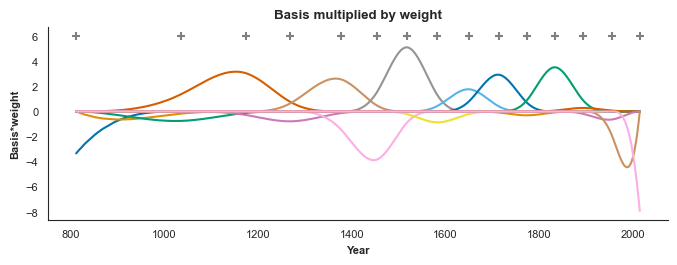

In [505]:
# Plot basis*weight
with sns.axes_style("white"):
    with sns.color_palette("colorblind"):
        # Make figure
        fig = plt.figure(figsize=(8,2.5))
        ax = fig.add_subplot()
        
        # Plot basis functions
        weighted_basis = pd.DataFrame(basis).mul(spline_model_trace["posterior"].mean(("chain","draw")).betas)
        ax.plot(d2.year.values, weighted_basis )
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        # Add knot markers
        ax.scatter(knot_list,np.ones((1,num_knots))+ 5,marker='+',color=grey)
        ax.set(xlabel="Year",
               ylabel="Basis*weight",
               title="Basis multiplied by weight")

Now let's check the fit of our model.

In [507]:
post = az.summary(spline_model_trace,var_names=["mu"])
post

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],100.335,3.143,94.461,106.240,0.048,0.034,4225.0,3000.0,1.0
mu[1],100.421,2.964,94.890,106.021,0.045,0.032,4306.0,3032.0,1.0
mu[2],100.841,2.177,96.725,104.843,0.031,0.022,4813.0,3115.0,1.0
mu[3],101.283,1.570,98.323,104.192,0.021,0.015,5460.0,2836.0,1.0
mu[4],101.323,1.530,98.377,104.097,0.021,0.015,5490.0,3023.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[822],95.906,1.700,92.875,99.178,0.024,0.017,5005.0,3067.0,1.0
mu[823],95.862,1.836,92.492,99.300,0.026,0.019,4871.0,3042.0,1.0
mu[824],95.823,1.986,92.276,99.668,0.029,0.020,4754.0,2810.0,1.0
mu[825],95.787,2.149,91.984,99.994,0.031,0.022,4656.0,2946.0,1.0


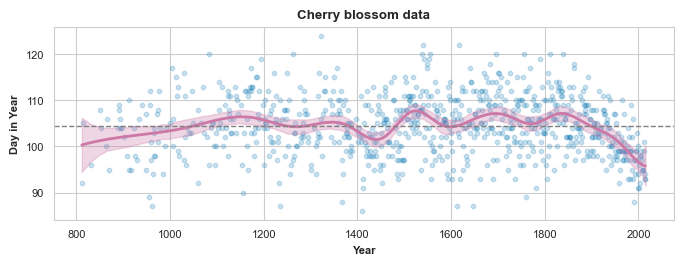

In [525]:

with sns.axes_style("whitegrid"):
    
    # Make figure
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_subplot()

    # Plot observed data
    ax.scatter(data=data,x="year",y="doy",color=blue_cb,alpha=0.2,s=10)

    # Get mean of posterior
    # yy = (weighted_basis.sum(axis=1) + spline_model_trace["posterior"].mean(("chain","draw")).alpha.data
     
    # Plot data and HDI
    ax.plot(d2.year.values, post["mean"],color=pink,lw=2)
    ax.fill_between(d2.year.values, post["hdi_3%"], post["hdi_97%"],color=pink,alpha=0.3)
    
    # Plot mean
    ax.axhline(y=data.doy.mean(),color=(0.5,0.5,0.5),linestyle='--',lw=1)

    # Clean up
    ax.set(xlabel = "Year",
           ylabel = "Day in Year",
           title  = "Cherry blossom data")